### Write a class with the following functions: 
- gp_model()
- minimize()
- set_initial_state()
- stim_state = sample()
- state_est = predict_state()
- transition_stete()


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy

In [2]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [9]:
# Import datasets as pandas
CA1_df = pd.read_csv(path)

# Get frequency and amplitudes
U1 = CA1_df.iloc[:,  0:2]
# Get the coordinate of pre stimulation gamma 
X0_coords = np.arange(33,52)

# sum of pre stimulation gamma
data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
X0_psd = X0_psd*1e10
lower_bound = np.min(U1)
upper_bound = np.max(U1)

X1_coords = np.arange(133,152)
X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
X1 =X1[:, np.newaxis] # reshape
X1 = X1*1e10 # bring to >0 range

 C:\Users\sinad\anaconda3\envs\NeuroGaussianProcess\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning:In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
 C:\Users\sinad\anaconda3\envs\NeuroGaussianProcess\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning:In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
 C:\Users\sinad\AppData\Local\Temp\ipykernel_25992\2398507421.py:18: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [13]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        
        # Import datasets as pandas
        CA1_df = pd.read_csv(csv_path)
        Y = np.sum(CA1_df.iloc[:, 133:152],axis=1)
        Y_reshape =Y[:, np.newaxis]
        Y_reshape = Y_reshape*1e10
        
        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, 33:52], axis=1)
        sum_preStim_gamma = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        sum_preStim_gamma = sum_preStim_gamma*1e10
        X = CA1_df.iloc[:,  0:2]
        X_preStim_gamma = X.join(sum_preStim_gamma)
        
        
        
        return ;
    
    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, X0_coords, U1, X1, lower_bound, upper_bound, X0_psd):
        # input_data
        X_preStim_gamma = U1.join(X0_psd)
        #GP model
        # define kernel
        ker = GPy.kern.Matern52(input_dim=3, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(3)
        
        # create simple GP model
        m = GPy.models.GPRegression(X_preStim_gamma,X1,ker)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(8,8))
        # GPy.plotting.change_plotting_library("matplotlib")
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        # Min and Max of State
        
        # Number of trials
        
        
        return X_preStim_gamma, X1, m; 
    
    
    #Minimize Function
    def minimize(self, m):
        
        
        return 
        
    

In [14]:
model = state_dr_gp()

 C:\Users\sinad\anaconda3\envs\NeuroGaussianProcess\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x19e23961c10>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x19e23961700>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0001   3.885537e+03   7.418182e+05 
    00s18  0004   1.895857e+03   1.949787e+04 
    01s44  0034   1.111442e+03   3.171993e-09 
Runtime:     01s44
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x19e2728b430>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x19e2902f2e0>]}

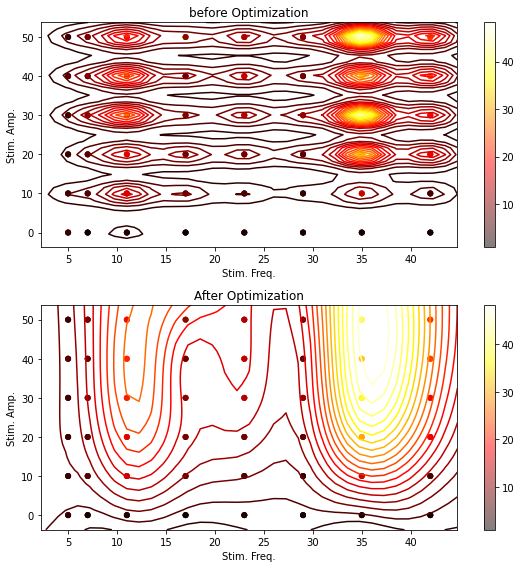

In [15]:
x, y, trained_model = model.initialize_data_dr_sim(X0_coords, U1, X1, lower_bound, upper_bound, X0_psd)
# print(x)

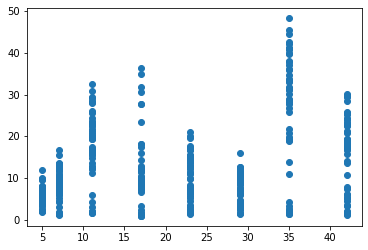

In [5]:
plt.scatter(x['Stim_1'],y)

In [62]:
data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
sum_preStim_gamma = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
sum_preStim_gamma = sum_preStim_gamma*1e10
sum_preStim_gamma

,sum_preStim_gamma
0,3.266571
1,2.425945
2,3.117866
3,2.868627
4,3.521665
...,...
379,1.268502
380,1.239859
381,1.880050
382,1.199899


In [60]:
np.arange(33,52)

array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51])

In [ ]:
arange